<a href="https://colab.research.google.com/github/rHarris4080/Capstone2/blob/main/SL_Used_Car_Price_Predictor_v3_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Capstone 2 - Supervised Learning: Predicting Used Car Listing Prices
#Robert L Harris 
###4/14/21
###4/20/21 Random Forest added
###3/8/22 More adjustments were made:


*   More EDA and cleaning performed.  
*   Scaled the continuous targets.
*   Dataset was separated into train, validation, and test sets.
*   Predictions were made on the hold-out test set and compared with actual price.


The dataset of interest was found on Kaggle.com.  It is composed of vehicles for sale on Craigslist.com compiled by Austin Reese.  The dataset has approximately 500k listings throughout the USA.  My computer was unable to download the entire csv file(267MB) do to hardware limitations.  Therefore, the file was split into 46 separate files having 10K listings apiece.  A looping algorithm was used to load in multiple files for investigation purposes.  The dataset was then filtered to only look at California listings.  Those listings were stored on 5 of the 46 files (vehicles_2.csv - vehicles_6.csv).  While California was the state of interest, the code could be easily adjusted to accommodate any state of interest.  One could even adjust it per generalized region (NW, W, SW, etc...).

##Task:
Write a Supervised Learning model to predict the appropriate asking price of an automobile for sale on Craigslist.com.  Our investigation will use California as the testing ground, but the model could be easily adjusted to look at any other state or region as stated earlier.

##Linear Regression: 
A linear regression approach will be pursued as the target listing price, a continuous variable, should increase on average over time.  Multiple models will be implemented once the dataset is cleaned and feature engineering is completed on all the categories of interest. 

##Stakeholders:
Anyone interested in listing their vehicle on Craigslist.com should have an idea of an appropriate listing price depending on particular parameters (i.e. make, model, miles, year, etc...).  If the best model gives an adequate result, then the individual would have a good idea of what to ask as a listing price for their vehicle.

##Limitations:
Unfortunately, the sale price is not of record.  Knowing the sale price would allow much more flexibility in the direction to pursue my analysis.  Predicting sale price is much more informative in my opinion that predicting the listing price.  Likewise, knowing the sales price along with listing price would allow for some basic inference regarding "if listing price with these features, then expect a possible sale price in this range as determined by some margin of error".  One would also be able to pursue the concept of maximizing sale price depending on differing factors.

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats

#Set up access the dataset
from google.colab import files 
import io

#vehicles_0 is loaded for column names.
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['vehicles_0.csv']))

Saving vehicles_0.csv to vehicles_0.csv


In [3]:
def get_data(file_csv):
  uploaded = files.upload() 
  df = pd.read_csv(io.BytesIO(uploaded[file_csv]))  
  return df

file_list = ['vehicles_2.csv', 'vehicles_3.csv', 'vehicles_4.csv',
             'vehicles_5.csv', 'vehicles_6.csv']

for file_csv in file_list:
  df_csv = get_data(file_csv)
  df_csv.columns = df.columns

  file = [df, df_csv]
  df = pd.concat(file, ignore_index=True)

Saving vehicles_2.csv to vehicles_2.csv


Saving vehicles_3.csv to vehicles_3.csv


Saving vehicles_4.csv to vehicles_4.csv


Saving vehicles_5.csv to vehicles_5.csv


Saving vehicles_6.csv to vehicles_6.csv


##Some preliminary investigation:

In [55]:
print(df.shape)
df.head(3)

(60000, 26)


,Unnamed: 0,id,url,region,region_url,price,year,manufacturer,model,condition,...,drive,size,type,paint_color,image_url,description,state,lat,long,posting_date
0,0,7240372487,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,35990,2010.0,chevrolet,corvette grand sport,good,...,rwd,NaN,other,NaN,https://images.craigslist.org/00N0N_ipkbHVZYf4...,Carvana is the safer way to buy a car During t...,al,32.590000,-85.480000,2020-12-02T08:11:30-0600
1,1,7240309422,https://auburn.craigslist.org/cto/d/auburn-201...,auburn,https://auburn.craigslist.org,7500,2014.0,hyundai,sonata,excellent,...,fwd,NaN,sedan,NaN,https://images.craigslist.org/00s0s_gBHYmJ5o7y...,I'll move to another city and try to sell my c...,al,32.547500,-85.468200,2020-12-02T02:11:50-0600
2,2,7240224296,https://auburn.craigslist.org/cto/d/auburn-200...,auburn,https://auburn.craigslist.org,4900,2006.0,bmw,x3 3.0i,good,...,NaN,NaN,SUV,blue,https://images.craigslist.org/00B0B_5zgEGWPOrt...,Clean 2006 BMW X3 3.0I. Beautiful and rare Bl...,al,32.616807,-85.464149,2020-12-01T19:50:41-0600


In [56]:
print(df.state.unique())
df.info()

['al' 'ak' 'az' 'ar' 'ca' 'co']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    60000 non-null  int64  
 1   id            60000 non-null  int64  
 2   url           60000 non-null  object 
 3   region        60000 non-null  object 
 4   region_url    60000 non-null  object 
 5   price         60000 non-null  int64  
 6   year          59867 non-null  float64
 7   manufacturer  57886 non-null  object 
 8   model         59322 non-null  object 
 9   condition     36805 non-null  object 
 10  cylinders     37209 non-null  object 
 11  fuel          59767 non-null  object 
 12  odometer      52222 non-null  float64
 13  title_status  59546 non-null  object 
 14  transmission  59743 non-null  object 
 15  VIN           37299 non-null  object 
 16  drive         41869 non-null  object 
 17  size          16886 non-null  object 

##Filter and investigate California:

In [57]:
# Filter CA listing only & reset index at 0
cars = df.copy()[df['state']=='ca']        #FYI: cars = df[df['state']=='ca']
cars.reset_index(drop=True, inplace=True)

cars.head(3)

,Unnamed: 0,id,url,region,region_url,price,year,manufacturer,model,condition,...,drive,size,type,paint_color,image_url,description,state,lat,long,posting_date
0,22141,7240678054,https://bakersfield.craigslist.org/ctd/d/fonta...,bakersfield,https://bakersfield.craigslist.org,74995,2019.0,ford,f-250sd,NaN,...,4wd,NaN,NaN,NaN,https://images.craigslist.org/00Y0Y_axZeBhuY2f...,2019 Ford F-250SD Lariat 4WD 4D Crew Cab 8 cy...,ca,34.070311,-117.446303,2020-12-02T14:01:31-0800
1,22142,7240677725,https://bakersfield.craigslist.org/ctd/d/orang...,bakersfield,https://bakersfield.craigslist.org,9997,2014.0,honda,civic bad credit,like new,...,NaN,NaN,SUV,black,https://images.craigslist.org/01616_c5SrAatbtj...,We offer HIGHLY AGGRESSIVE financing for those...,ca,33.788216,-117.833248,2020-12-02T14:00:56-0800
2,22143,7240673013,https://bakersfield.craigslist.org/ctd/d/orang...,bakersfield,https://bakersfield.craigslist.org,23997,2015.0,nissan,armada bad credit,excellent,...,NaN,NaN,SUV,black,https://images.craigslist.org/00n0n_a18VfwAZOT...,"😍 We are very pleased to offer for sale this ""...",ca,33.811000,-117.849300,2020-12-02T13:53:15-0800


###Only 16 of the original 26 categories are of interest.  We will eliminate the categories having little to no effect on the target price.  Those columns are:
1. Unamed:0
2. id
3. url
4. region_url
5. VIN
6. image_url
7. descriprion
8. lat
9. long
10. posting_date


In [58]:
cars.drop(columns = ['Unnamed: 0', 'id','url','region_url','VIN','image_url', 'description','lat', 'long', 'posting_date'], inplace=True ) 
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45634 entries, 0 to 45633
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   region        45634 non-null  object 
 1   price         45634 non-null  int64  
 2   year          45573 non-null  float64
 3   manufacturer  44028 non-null  object 
 4   model         45076 non-null  object 
 5   condition     29714 non-null  object 
 6   cylinders     27506 non-null  object 
 7   fuel          45488 non-null  object 
 8   odometer      40144 non-null  float64
 9   title_status  45344 non-null  object 
 10  transmission  45451 non-null  object 
 11  drive         31547 non-null  object 
 12  size          12860 non-null  object 
 13  type          36028 non-null  object 
 14  paint_color   31669 non-null  object 
 15  state         45634 non-null  object 
dtypes: float64(2), int64(1), object(13)
memory usage: 5.6+ MB


### Remove entries without a year because year is a key feature.

In [59]:
print(cars.year.isnull().value_counts())

cars = cars[cars['year'].notna()] 

print(len(cars[cars['year'].isnull()==True]))
print(len(cars))

False    45573
True        61
Name: year, dtype: int64
0
45573


##Continue to explore and clean continuous variables:

In [60]:
cars.describe().apply(lambda x: x.apply('{0:.0f}'.format))

,price,year,odometer
count,45573,45573,40083
mean,77951,2011,87808
std,13155229,10,162308
min,0,1900,0
25%,5950,2008,36103
50%,12500,2013,75000
75%,22985,2016,120000
max,2808348671,2021,10000000


###Investigate a minimum odometer and price reading of 0.  Also, max price of $2,808,348,671 and a max odometer of 10,000,000?  From the Rich and Famous to the poster child for using Firestone to prolong the life of your car!!!

In [61]:
print(len(cars[cars['odometer']==0]))
print(len(cars[cars['price']==0]))

352
3725


###Eliminate all records where price = 0

In [62]:
cars.drop(cars[cars.price == 0].index, inplace=True)
len(cars[cars.price == 0])

0

In [63]:
# Investigate odometer issues:

cars[cars['odometer']==0].head(5)

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
171,bakersfield,39990,2014.0,NaN,John Deere Loader,excellent,NaN,gas,0.0,clean,automatic,NaN,NaN,NaN,orange,ca
174,bakersfield,12990,2020.0,NaN,CTEC 128-38-VFT-95,excellent,NaN,gas,0.0,clean,automatic,NaN,NaN,NaN,white,ca
1387,bakersfield,6498,2008.0,honda,cr-v,excellent,4 cylinders,gas,0.0,clean,automatic,fwd,NaN,SUV,blue,ca
2653,chico,4995,2002.0,chevrolet,trailblazer,good,6 cylinders,gas,0.0,clean,automatic,4wd,mid-size,SUV,red,ca
2992,chico,8999,2010.0,nissan,murano,excellent,6 cylinders,gas,0.0,clean,automatic,4wd,NaN,SUV,NaN,ca


In [64]:
cars[cars['odometer'].isnull()==True].head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
212,bakersfield,7975,2014.0,chevrolet,traverse,excellent,6 cylinders,gas,NaN,clean,automatic,fwd,full-size,SUV,black,ca
213,bakersfield,6975,2014.0,buick,verano,excellent,4 cylinders,gas,NaN,clean,automatic,fwd,mid-size,sedan,black,ca
216,bakersfield,9997,2014.0,honda,civic bad credit,like new,NaN,gas,NaN,clean,automatic,NaN,NaN,SUV,black,ca
217,bakersfield,7975,2012.0,ford,mustang,excellent,6 cylinders,gas,NaN,clean,automatic,fwd,mid-size,convertible,black,ca
218,bakersfield,6800,2012.0,honda,civic,NaN,NaN,gas,NaN,clean,automatic,NaN,NaN,sedan,NaN,ca


## We are not willing to give up on a 0 or Nan odometer readings just yet.  This might have just been forgotten in the listing for some reason.  So we will sort the data and fill with a rolling average of the surrounding 50 odometer readings relative to manufacturer, model, and year.

In [65]:
# Replace all odometer readings of 0 to NaN for the following cell that converts Nan values to the rolling average of 25 surrounding values.
cars['odometer'].loc[(cars['odometer'] == 0.0)] = np.nan

cars_t = cars.copy()
cars_t.sort_values(by=['manufacturer', 'model', 'year'], inplace=True)

cars_t['odometer'].fillna(cars_t['odometer'].rolling(50, min_periods=1).mean(), inplace=True)
cars_t.sort_values(by=['region'], inplace=True, ascending=False)

cars = cars_t
print(len(cars[cars['odometer'].isnull()==True]))
print(len(cars[cars['odometer']==0]))

0
0


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [66]:
# Typecast odometer and year to int
cars.reset_index(drop=True, inplace=True)
cars['odometer'] = cars['odometer'].astype(int)
cars['year'] = cars['year'].astype(int)

print(cars.shape)
cars.head()

(41848, 16)


,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
0,yuba-sutter,6999,2002,saturn,ls,excellent,6 cylinders,gas,38657,clean,automatic,NaN,NaN,sedan,NaN,ca
1,yuba-sutter,17999,2008,gmc,sierra 1500,excellent,8 cylinders,gas,145327,clean,automatic,4wd,full-size,pickup,black,ca
2,yuba-sutter,17999,2008,gmc,sierra 1500,excellent,8 cylinders,gas,145327,clean,automatic,4wd,full-size,pickup,black,ca
3,yuba-sutter,10988,2010,mercedes-benz,ml-350 diesel - awd - navi - rear camera -,excellent,6 cylinders,diesel,70483,clean,automatic,4wd,NaN,SUV,black,ca
4,yuba-sutter,10988,2010,mercedes-benz,ml-350 diesel - awd - navi - rear camera -,excellent,6 cylinders,diesel,69942,clean,automatic,4wd,NaN,SUV,black,ca


###Checking continuous variable outliers:

In [67]:
# Determine number of outliers:

def tukey_IQR(cars, col):
  q75, q25 = np.percentile(cars[col], [75 ,25])
  iqr = q75 - q25

  for threshold in np.arange(1,2,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("\tThe score threshold is: {}".format(threshold))
    print("\tNumber of outliers is: {}".format(
        len((np.where((cars[col] > max_val) 
                      | (cars[col] < min_val))[0]))
    ))

In [68]:
print("Price Outliers -  Tukey IQR:")
tukey_IQR(cars, "price")

print("\nTukey IQR Outliers -  odometer:")
tukey_IQR(cars, "odometer")

Price Outliers -  Tukey IQR:
	The score threshold is: 1.0
	Number of outliers is: 2551
	The score threshold is: 1.5
	Number of outliers is: 1383

Tukey IQR Outliers -  odometer:
	The score threshold is: 1.0
	Number of outliers is: 1719
	The score threshold is: 1.5
	Number of outliers is: 675


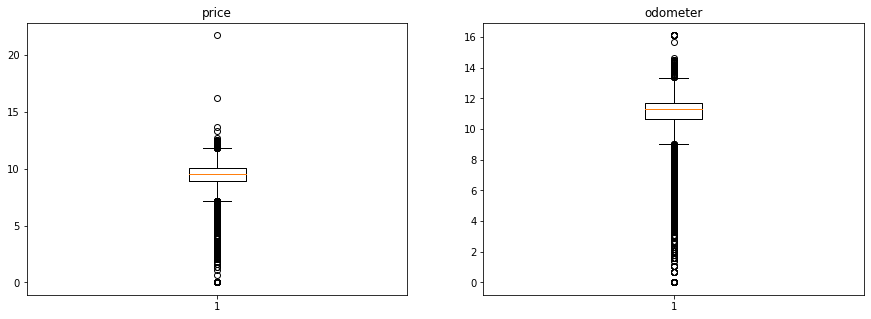

In [16]:
# Box Plot visualizing investigating outliers
plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.boxplot(np.log(cars["price"]), whis=1.5)
plt.title("price")

plt.subplot(1,2,2)
plt.boxplot(np.log(cars["odometer"]), whis=1.5)
plt.title("odometer")
plt.show()

In [69]:
cars.price.sort_values()

27146             1
31433             1
33039             1
31439             1
36270             1
            ...    
12462        339998
23749        599000
10785        888777
36710      11111111
27383    2808348671
Name: price, Length: 41848, dtype: int64

In [18]:
cars.odometer.sort_values()

40047           1
4963            1
40705           1
39741           1
8862            1
           ...   
41141    10000000
32507    10000000
10929    10000000
32812    10000000
30662    10000000
Name: odometer, Length: 41848, dtype: int64

##Outlier approach:  
###Extreme price and odometer outliers do not contribute to developing a good predictive model for determing the appropriate listing price.  Therefore, we will remove two-tailed price and odometer outliers at q1=0.05 and q3=0.95. 

In [70]:
def filter_outlier(cars, col):
  q_low = cars[col].quantile(0.05)
  q_hi  = cars[col].quantile(0.95)

  cars = cars[(cars[col] < q_hi) & (cars[col] > q_low)]

  print("\nTukey IQR Outliers -  ", col, ":")
  tukey_IQR(cars, col)

  return cars

In [71]:
cars = filter_outlier(cars, "price")
cars = filter_outlier(cars, 'odometer')


Tukey IQR Outliers -   price :
	The score threshold is: 1.0
	Number of outliers is: 1352
	The score threshold is: 1.5
	Number of outliers is: 0

Tukey IQR Outliers -   odometer :
	The score threshold is: 1.0
	Number of outliers is: 169
	The score threshold is: 1.5
	Number of outliers is: 0


In [72]:
cars.shape

(33864, 16)

##Visually show outliers removed.

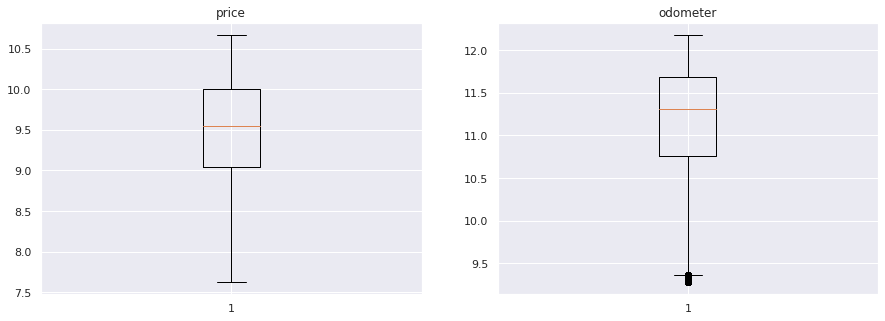

In [73]:
plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.boxplot(np.log(cars["price"]), whis=1.5)
plt.title("price")

plt.subplot(1,2,2)
plt.boxplot(np.log(cars["odometer"]), whis=1.5)
plt.title("odometer")
plt.show()

####Much cleaner looking continuous variables.

In [74]:
# Confirm stability of continuous numeric values after removing outliers:

cars.describe().apply(lambda x: x.apply('{0:.0f}'.format))

,price,year,odometer
count,33864,33864,33864
mean,16102,2011,85583
std,9740,9,45963
min,2050,1900,10742
25%,8495,2008,47000
50%,13990,2013,81868
75%,21999,2016,118664
max,42988,2021,194144


###Investigating the year.

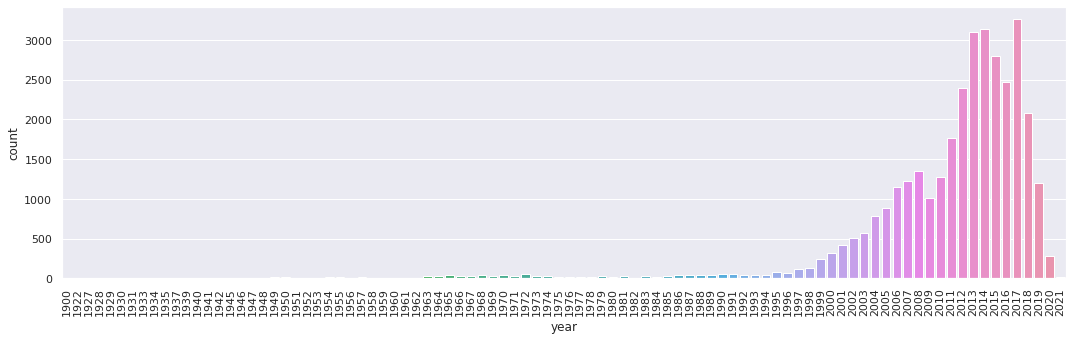

In [75]:
# YEAR
plt.figure(figsize=(18,5))
sns.set_theme(style="darkgrid")
stat = sns.countplot(x="year", data=cars)
var = stat.set_xticklabels(stat.get_xticklabels(), rotation=90)

###It appears we are looking at too many model years.  At some point cars at a certain age become collectors, antiques, or just too difficult to quantify.  So we will filter our cars from the year 2000 to present 2021.  We will continue to tweak and clean data as we see fit.

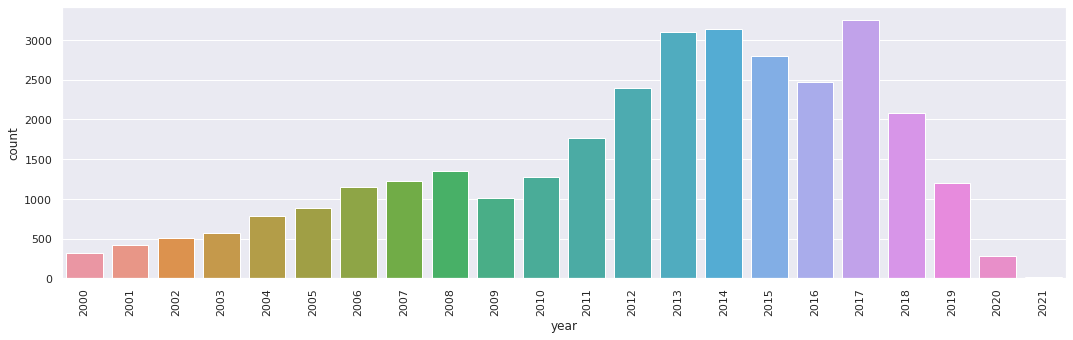

In [76]:
cars = cars[cars.year >= 2000]

plt.figure(figsize=(18,5))
sns.set_theme(style="darkgrid")
stat = sns.countplot(x="year", data=cars)
var = stat.set_xticklabels(stat.get_xticklabels(), rotation=90)

###Take a quick look at max pricing.

In [77]:
# Take a quick look at price because Max price seems a bit low.
cars.sort_values(by=['price'], ascending=False).head(3)

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
38873,bakersfield,42988,2018,mercedes-benz,gle,excellent,NaN,gas,37722,clean,automatic,4wd,NaN,SUV,NaN,ca
9330,san diego,42988,2018,lexus,gx460 4wd,excellent,8 cylinders,gas,22129,clean,automatic,4wd,NaN,SUV,black,ca
15529,reno / tahoe,42987,2017,toyota,tacoma,NaN,NaN,other,24823,clean,automatic,4wd,NaN,pickup,silver,ca


##Categorical variables:

In [78]:
#Investigate nulls

Nan_sum = cars.isnull().sum()
Nan_sum

region              0
price               0
year                0
manufacturer      710
model             152
condition        9785
cylinders       12153
fuel              124
odometer            0
title_status      105
transmission      163
drive            9897
size            23505
type             5792
paint_color      8951
state               0
dtype: int64

In [79]:
# What percent are null 
cars.isnull().mean()

region          0.000000
price           0.000000
year            0.000000
manufacturer    0.022194
model           0.004751
condition       0.305867
cylinders       0.379888
fuel            0.003876
odometer        0.000000
title_status    0.003282
transmission    0.005095
drive           0.309368
size            0.734738
type            0.181051
paint_color     0.279797
state           0.000000
dtype: float64

###Eliminate any category having more than 40% null values:

In [81]:
cars.drop(cars.columns[cars.apply(lambda col: col.isnull().mean() > 0.4)], axis=1, inplace=True)

In [82]:
# Variable size has been eliminated because 73% is missing from listings.
cars.columns

Index(['region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission',
       'drive', 'type', 'paint_color', 'state'],
      dtype='object')

###Categorical investigation.
1. Replace nan with appropriate alternative
2. Investigate and consider encoding options for categorical features.

In [83]:
cars.manufacturer.unique()

array(['saturn', 'gmc', 'mercedes-benz', 'lincoln', 'ram', 'infiniti',
       'chevrolet', 'kia', 'ford', nan, 'audi', 'toyota', 'volkswagen',
       'buick', 'bmw', 'jeep', 'mazda', 'subaru', 'jaguar', 'lexus',
       'rover', 'cadillac', 'hyundai', 'volvo', 'mini', 'mitsubishi',
       'mercury', 'dodge', 'honda', 'nissan', 'porsche', 'acura',
       'chrysler', 'pontiac', 'fiat', 'tesla', 'aston-martin',
       'alfa-romeo', 'harley-davidson', 'land rover'], dtype=object)

In [84]:
cars[cars["manufacturer"].isnull()==True]

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
36,yuba-sutter,4995,2005,NaN,SUBARUMLEGACY SEDAN,good,4 cylinders,gas,169000,clean,automatic,4wd,sedan,blue,ca
107,yuba-sutter,28500,2012,NaN,INTERNATIONAL WATER TRUCK,NaN,NaN,diesel,130915,clean,manual,NaN,NaN,NaN,ca
181,yuba-sutter,12999,2007,NaN,Hummer H3,excellent,5 cylinders,gas,152809,clean,automatic,4wd,SUV,NaN,ca
185,yuba-sutter,9999,2006,NaN,Hummer H3,excellent,5 cylinders,gas,187032,clean,automatic,4wd,NaN,black,ca
194,yuba-sutter,9999,2006,NaN,Hummer H3,excellent,5 cylinders,gas,187032,clean,automatic,4wd,NaN,black,ca
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40483,SF bay area,11901,2016,NaN,Scion iM,NaN,4 cylinders,gas,51581,clean,automatic,fwd,hatchback,silver,ca
40535,SF bay area,8988,2005,NaN,SAAB 9-2X,NaN,NaN,gas,107444,clean,manual,NaN,hatchback,blue,ca
41376,SF bay area,8500,2001,NaN,2001 F-550,fair,8 cylinders,diesel,170000,clean,other,rwd,truck,white,ca
41378,SF bay area,25000,2002,NaN,2002 Eurovan,NaN,NaN,gas,80000,clean,automatic,NaN,NaN,NaN,ca


In [85]:
cars[cars["manufacturer"]=='other']

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state


###Rearranging text from model to manufacturer is outside the scope of this investigation.  Therefore, we will drop these 710 entries.

In [86]:
cars = cars[cars["manufacturer"].isnull()!=True]
cars = cars[cars["manufacturer"]!='other']
len(cars)

31281

In [87]:
# delete 'harley-davidson' as we are looking at cars not motorcycles.
cars.drop(cars[cars['manufacturer']=='harley-davidson'].index, inplace=True)


In [88]:
print("condition: ", cars.condition.unique())
print("\nmodel: ", cars.model.unique())
print("\nfuel: ", cars.fuel.unique())
print("\nCylinders: ",cars.cylinders.unique())
print("\ntitle_status: ", cars.title_status.unique())
print("\ntransmission: ", cars.transmission.unique())
print("\ndrive: ", cars.drive.unique())
print("\npaint_color: ", cars.paint_color.unique())
print("\ntype: ", cars.type.unique())

condition:  ['excellent' 'good' nan 'like new' 'salvage' 'fair' 'new']

model:  ['ls' 'sierra 1500' 'ml-350 diesel - awd - navi - rear camera -' ...
 'routan sel' 'rav4 limited 4x4' 'clarity plug-in hybrid touring']

fuel:  ['gas' 'diesel' 'other' 'hybrid' 'electric' nan]

Cylinders:  ['6 cylinders' '8 cylinders' nan '4 cylinders' '5 cylinders'
 '10 cylinders' '3 cylinders' 'other' '12 cylinders']

title_status:  ['clean' 'lien' 'salvage' 'missing' nan 'rebuilt' 'parts only']

transmission:  ['automatic' 'other' 'manual' nan]

drive:  [nan '4wd' 'rwd' 'fwd']

paint_color:  [nan 'black' 'silver' 'white' 'grey' 'blue' 'red' 'brown' 'green' 'orange'
 'yellow' 'custom' 'purple']

type:  ['sedan' 'pickup' 'SUV' nan 'van' 'truck' 'hatchback' 'convertible'
 'other' 'wagon' 'coupe' 'mini-van' 'offroad' 'bus']


In [89]:
# replace Nan with 'other' or category mode for 'title', 'transmission', and 'title_status'.
categories = ['transmission', 'fuel', 'title_status', 'manufacturer', 
              'model', 'condition', 'cylinders', 'drive', 'type', 'paint_color']

for col in categories:
  cars[col].fillna('other', inplace=True)

cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31274 entries, 0 to 41847
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   region        31274 non-null  object
 1   price         31274 non-null  int64 
 2   year          31274 non-null  int64 
 3   manufacturer  31274 non-null  object
 4   model         31274 non-null  object
 5   condition     31274 non-null  object
 6   cylinders     31274 non-null  object
 7   fuel          31274 non-null  object
 8   odometer      31274 non-null  int64 
 9   title_status  31274 non-null  object
 10  transmission  31274 non-null  object
 11  drive         31274 non-null  object
 12  type          31274 non-null  object
 13  paint_color   31274 non-null  object
 14  state         31274 non-null  object
dtypes: int64(3), object(12)
memory usage: 3.8+ MB


In [90]:
cars.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
0,yuba-sutter,6999,2002,saturn,ls,excellent,6 cylinders,gas,38657,clean,automatic,other,sedan,other,ca
1,yuba-sutter,17999,2008,gmc,sierra 1500,excellent,8 cylinders,gas,145327,clean,automatic,4wd,pickup,black,ca
2,yuba-sutter,17999,2008,gmc,sierra 1500,excellent,8 cylinders,gas,145327,clean,automatic,4wd,pickup,black,ca
3,yuba-sutter,10988,2010,mercedes-benz,ml-350 diesel - awd - navi - rear camera -,excellent,6 cylinders,diesel,70483,clean,automatic,4wd,SUV,black,ca
4,yuba-sutter,10988,2010,mercedes-benz,ml-350 diesel - awd - navi - rear camera -,excellent,6 cylinders,diesel,69942,clean,automatic,4wd,SUV,black,ca


## All variables have been cleaned up through Exploratory Data Analysis(EDA).  We will gather a bit more perspective through visualizations before we develop our Supervised Learning Model.

#Variable visualization:

###I. Categorical features:

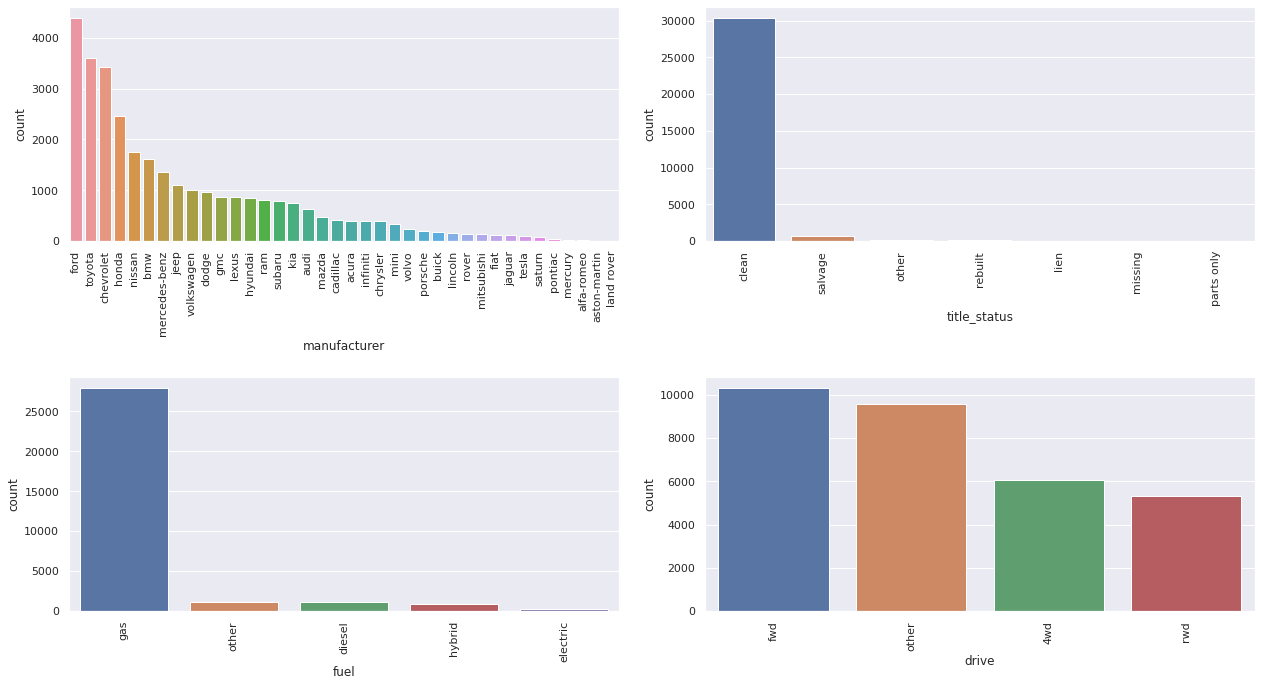

In [91]:
col_t = ['manufacturer', 'title_status', 'fuel', 'drive']
#, 'fuel','title_status', 'transmission', 'drive', 'size', 'type', 'paint_color'

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,10))

for i, var in enumerate(col_t):
  row = i//2
  col = i % 2
  plot = sns.countplot(x=var, data=cars, order = cars[var].value_counts().index, ax=axs[row][col])
  var = plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
fig.tight_layout(pad=2.0)

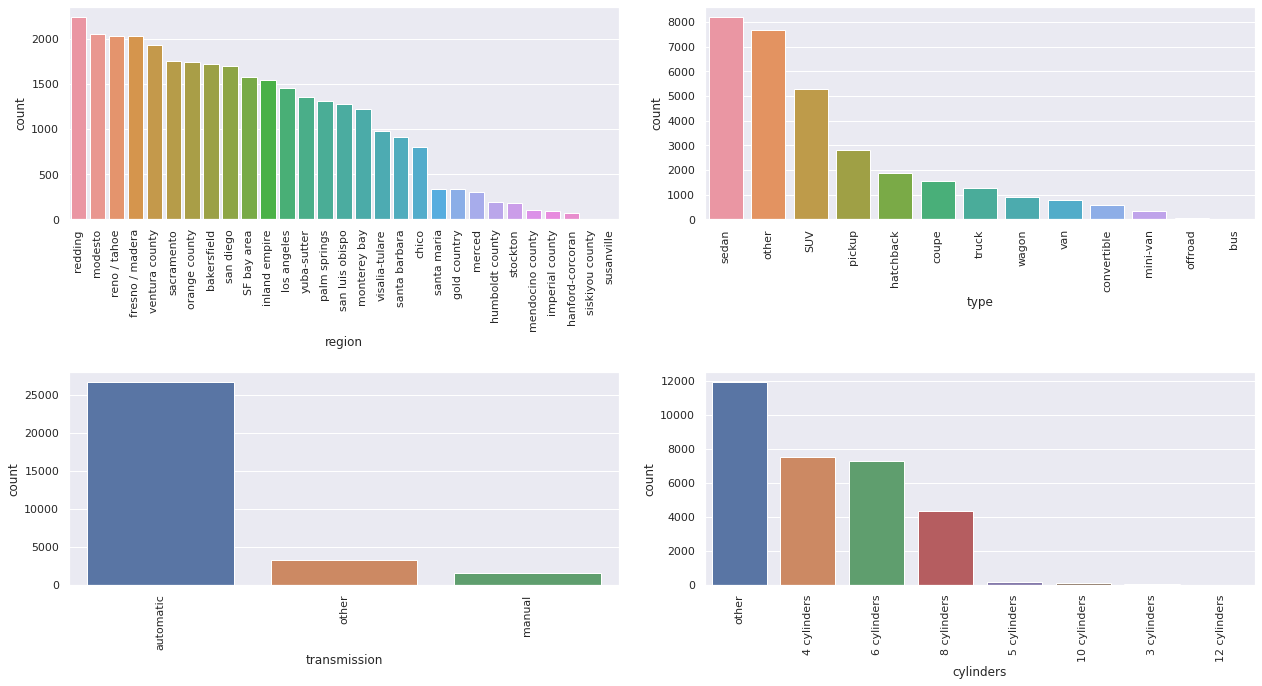

In [92]:
col_t2 = ['region', 'type', 'transmission','cylinders']
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18, 10)) 

for i, var in enumerate(col_t2):
    row = i//2
    col = i % 2    
    plot = sns.countplot(x=var, data=cars, order = cars[var].value_counts().index, ax=axs[row][col])
    var = plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
fig.tight_layout(pad=2.0)

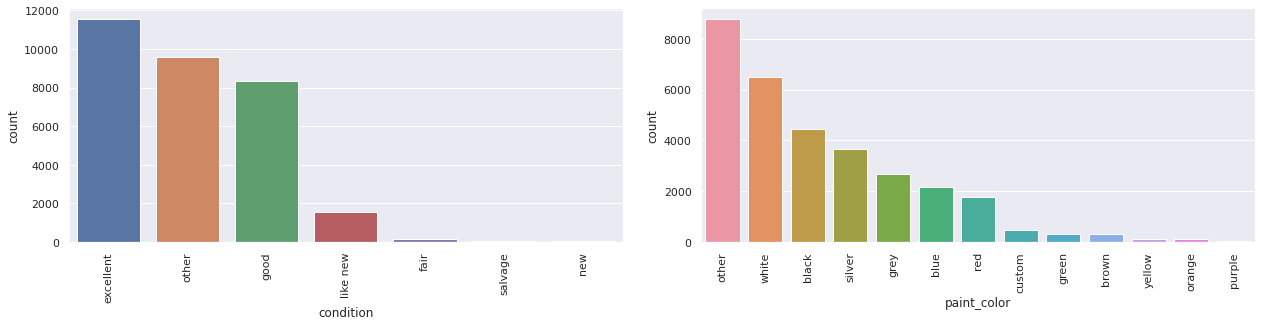

In [93]:
col = ['condition', 'paint_color']

fig, axs = plt.subplots(ncols=2, figsize=(18,5))

for i, var in enumerate(col):
  row = i//2
  col = i % 2
  plot = sns.countplot(x=var, data=cars, order = cars[var].value_counts().index, ax=axs[col])
  var = plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
fig.tight_layout(pad=2.0)

###Price Comparisons.

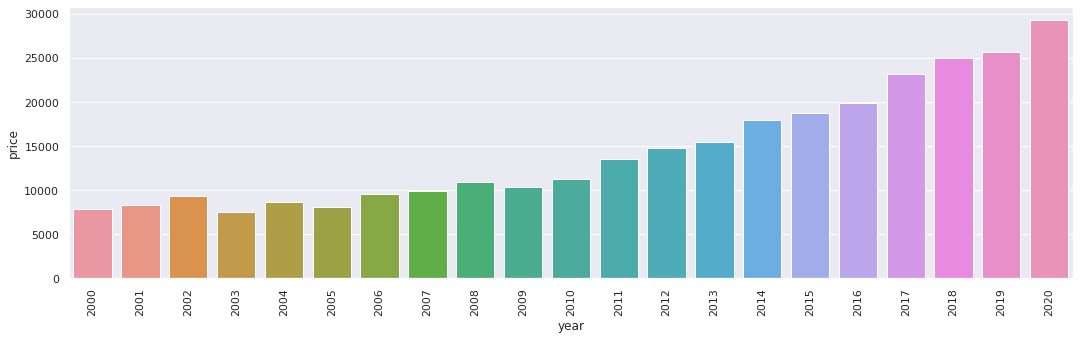

In [94]:
# Mean price per year

price_ave = cars[['price','year']].groupby('year').mean()

plt.figure(figsize=(18,5))
pr = sns.barplot(x=price_ave.index, y="price", data=price_ave)
var = pr.set_xticklabels(pr.get_xticklabels(), rotation=90)

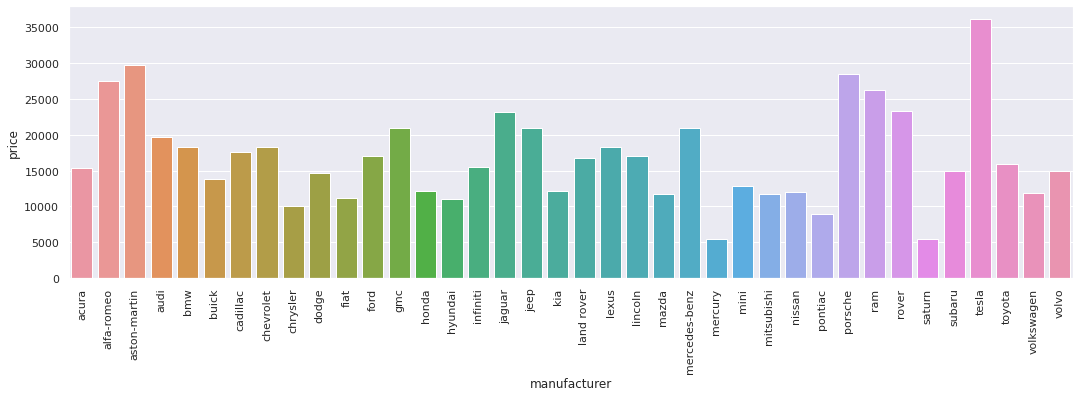

In [95]:
# Average Price per Manufacturer

ave_price_make = cars[['price','manufacturer']].groupby('manufacturer').mean()

plt.figure(figsize=(18,5))
pr = sns.barplot(x=ave_price_make.index, y="price", data=ave_price_make)
var = pr.set_xticklabels(pr.get_xticklabels(), rotation=90)
var = stat.set_xticklabels(stat.get_xticklabels(), rotation=90)

#Categorical Feature Engineering:

##Encoding:
###1. Fuel, transmission, and title to binary: gas/!gas, automatic/!automatic, clean/!clean
###2. Manufacturer needs to be given a numerical value.  So we will convert to a continuous value representing the average price of that manufacturer per year.
###3. Model will likewise be converted to a numerical value representing the average price per manufacturer, per model, per corresponding year.  
###4. The remaining categorical features will be encoded with dummies.

In [137]:
clean_cars = cars.copy()

In [138]:
# cars2 will become the transformed dataframe we will use for training and evaulating models.
#cars2 = cars.copy()

# 1. Binary
equiv_values = {
                "transmission": {"automatic": 1, "manual":0, "other":0},
                "title_status": {"clean": 1, "salvage":0, "missing":0, "lien":0, "other":0, "rebuilt":0, "parts only":0 },
                "fuel":         {"gas": 1, "hybrid":0, "diesel":0, "electric":0, "other":0},
}

clean_cars = clean_cars.replace(equiv_values)

clean_cars.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
0,yuba-sutter,6999,2002,saturn,ls,excellent,6 cylinders,1,38657,1,1,other,sedan,other,ca
1,yuba-sutter,17999,2008,gmc,sierra 1500,excellent,8 cylinders,1,145327,1,1,4wd,pickup,black,ca
2,yuba-sutter,17999,2008,gmc,sierra 1500,excellent,8 cylinders,1,145327,1,1,4wd,pickup,black,ca
3,yuba-sutter,10988,2010,mercedes-benz,ml-350 diesel - awd - navi - rear camera -,excellent,6 cylinders,0,70483,1,1,4wd,SUV,black,ca
4,yuba-sutter,10988,2010,mercedes-benz,ml-350 diesel - awd - navi - rear camera -,excellent,6 cylinders,0,69942,1,1,4wd,SUV,black,ca


## Investigate manufacturer and model averages:

In [139]:
clean_cars[['manufacturer', 'price','year']].groupby('manufacturer').mean().head().apply(lambda x: x.apply('{0:.0f}'.format))

,price,year
manufacturer,,
acura,15377,2012
alfa-romeo,27486,2018
aston-martin,29750,2004
audi,19681,2013
bmw,18262,2012


In [140]:
# 2. Encoding avg_price_make

# Reset index for work around below:
clean_cars.reset_index(drop=True, inplace=True)

# Create a new column for the average price per manufacturer:
clean_cars['ave_price_make'] = pd.Series(dtype = 'float')

# Work Around - Fill in average price per make for a generalized manufacturer valuation.
avg_price = clean_cars[['manufacturer', 'price','year']].groupby('manufacturer').mean()        # Added 'year'

for recd in range(len(clean_cars)):
  clean_cars['ave_price_make'][recd] = avg_price.loc[clean_cars['manufacturer'][recd]][0]

clean_cars.reset_index(drop=True, inplace=True)
clean_cars.head(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,ave_price_make
0,yuba-sutter,6999,2002,saturn,ls,excellent,6 cylinders,1,38657,1,1,other,sedan,other,ca,5437.273
1,yuba-sutter,17999,2008,gmc,sierra 1500,excellent,8 cylinders,1,145327,1,1,4wd,pickup,black,ca,20951.032
2,yuba-sutter,17999,2008,gmc,sierra 1500,excellent,8 cylinders,1,145327,1,1,4wd,pickup,black,ca,20951.032


##Adding an average price per model (ave_price_model) to quantify significance of a particular vehicles attributes relative to it's year and asking price.

In [141]:
#3. Encoding ave_price_model

# Some initial investigation into accessing desired data:
clean_cars[['manufacturer', 'price']].groupby('manufacturer').mean()
apm = pd.DataFrame(clean_cars.groupby(['manufacturer', 'model', 'year']).price.mean())
apm

price
manufacturer model                    year          
acura        3.2 tl                   2004  5999.000
                                      2010 10995.000
             ilk                      2015 14000.000
             ilx                      2013 13999.000
                                      2014 14845.000
...                                              ...
volvo        xc90 awd t6              2004  6800.000
             xc90 t6 awd              2004  4800.000
                                      2017 36900.000
             xc90 t6 awd momentum     2018 37977.000
             xc90 t6 miles 20,000 low 2018 37977.000

[10535 rows x 1 columns]

In [142]:
# Code to add 'ave_price_model' category to cars2: 
clean_cars['ave_price_model'] = clean_cars.groupby(['manufacturer','model','year'])['price'].transform(lambda x: x.mean())

clean_cars.head(3)

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,ave_price_make,ave_price_model
0,yuba-sutter,6999,2002,saturn,ls,excellent,6 cylinders,1,38657,1,1,other,sedan,other,ca,5437.273,6999.000
1,yuba-sutter,17999,2008,gmc,sierra 1500,excellent,8 cylinders,1,145327,1,1,4wd,pickup,black,ca,20951.032,17399.100
2,yuba-sutter,17999,2008,gmc,sierra 1500,excellent,8 cylinders,1,145327,1,1,4wd,pickup,black,ca,20951.032,17399.100


In [143]:
#4. One-Hot Encode dummies
df_encoded = clean_cars.copy()

oh_enc_cols = ["condition", "cylinders", "drive", "type", "paint_color"]
df_encoded = pd.get_dummies(df_encoded, columns=oh_enc_cols)

df_encoded.head(3)

,region,price,year,manufacturer,model,fuel,odometer,title_status,transmission,state,...,paint_color_custom,paint_color_green,paint_color_grey,paint_color_orange,paint_color_other,paint_color_purple,paint_color_red,paint_color_silver,paint_color_white,paint_color_yellow
0,yuba-sutter,6999,2002,saturn,ls,1,38657,1,1,ca,...,0,0,0,0,1,0,0,0,0,0
1,yuba-sutter,17999,2008,gmc,sierra 1500,1,145327,1,1,ca,...,0,0,0,0,0,0,0,0,0,0
2,yuba-sutter,17999,2008,gmc,sierra 1500,1,145327,1,1,ca,...,0,0,0,0,0,0,0,0,0,0


In [144]:
#Drop remaining categoric features:
df_encoded.drop(['state', 'manufacturer', 'model'], axis=1, inplace=True) 

Scale the numeric features. 

In [145]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scale_cols = ['year', 'odometer',	'ave_price_make', 'ave_price_model']
df_encoded[scale_cols] = scaler.fit_transform(df_encoded[scale_cols])

df_encoded.head(3)


,region,price,year,fuel,odometer,title_status,transmission,ave_price_make,ave_price_model,condition_excellent,...,paint_color_custom,paint_color_green,paint_color_grey,paint_color_orange,paint_color_other,paint_color_purple,paint_color_red,paint_color_silver,paint_color_white,paint_color_yellow
0,yuba-sutter,6999,0.100,1,0.152,1,1,0.000,0.120,1,...,0,0,0,0,1,0,0,0,0,0
1,yuba-sutter,17999,0.400,1,0.734,1,1,0.505,0.374,1,...,0,0,0,0,0,0,0,0,0,0
2,yuba-sutter,17999,0.400,1,0.734,1,1,0.505,0.374,1,...,0,0,0,0,0,0,0,0,0,0


In [146]:
df_encoded.drop(['region'], axis=1, inplace=True) 

# Feature Engineering is completed.  Time to train, validate, and evaluate differing models.  We will have a 10 element hold out test set to see how our best model performs.

###First, extract a test sample of 10 vehicles.

In [147]:
# Pull 10 entries out for testing predictions
import random

# Indices are the original dataframe index values
indices = random.sample(range(1, len(df_encoded)),10)

test_df = pd.DataFrame(columns=df_encoded.columns)
for i, index in enumerate(indices):
  test_df.loc[i] = df_encoded.iloc[index]

# Remove these 10 entries from df_encoded
df_encoded = df_encoded.drop(labels=indices, axis=0)

# FYI: test_df.iloc[0] == cars.iloc[indices[0]]
test_df_price = test_df['price']
test_df.drop(columns=['price'], axis=1, inplace=True)

test_df_price

0   22990.000
1    8995.000
2   32498.000
3   22999.000
4    5400.000
5   21899.000
6    7293.000
7    8750.000
8   14899.000
9   10990.000
Name: price, dtype: float64

In [148]:
# 1st entry in test_df
cars.iloc[indices[0]] # == test_df.iloc[0]

region                      santa barbara
price                               22990
year                                 2014
manufacturer                         audi
model           q7 tdi premium plus sport
condition                            good
cylinders                     6 cylinders
fuel                               diesel
odometer                            88427
title_status                        clean
transmission                    automatic
drive                               other
type                                other
paint_color                          blue
state                                  ca
Name: 6781, dtype: object

In [153]:
# Indices taken from cars for test file 'test_df'
indices

[5164, 27279, 28364, 13351, 17563, 10410, 7490, 12247, 29720, 25072]

###Here are the first 3 entries in the test_cars datafile.

In [163]:
test_cars = cars.iloc[indices]
test_cars = test_cars.reset_index(drop=True)
test_cars.head(3)

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
0,santa barbara,22990,2014,audi,q7 tdi premium plus sport,good,6 cylinders,diesel,88427,clean,automatic,other,other,blue,ca
1,chico,8995,2007,honda,pilot,excellent,6 cylinders,gas,140048,clean,automatic,4wd,SUV,grey,ca
2,bakersfield,32498,2020,mercedes-benz,a-class,excellent,other,gas,119089,clean,automatic,fwd,sedan,other,ca


###Begin Modeling.

In [164]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse

pd.options.display.float_format = '{:.3f}'.format

# Establish the Target
Y = df_encoded['price']
 
# Set the Features
X = df_encoded.drop(columns=['price'], axis=1)

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_val.shape[0]))

The number of observations in training set is 25011
The number of observations in test set is 6253


###Helper methods for Metrics and Cross-Validation:

In [165]:
def eval_metrics(y_val, y_preds_val):
  print("\nMAE:\t{:.5f}".format(mean_absolute_error(y_val, y_preds_val)))
  print("MSE:\t{:.5f}".format(mse(y_val, y_preds_val)))
  print("RMSE:\t{:.5f}".format(rmse(y_val, y_preds_val)))
  print("MAPE:\t{:.5f}".format(np.mean(np.abs((y_val - y_preds_val) / y_val)) * 100))

In [166]:
def test_results(model):
  accuracy = cross_val_score(model, X, Y, cv=5)
  print("\nCross-Validation mean:\t\t{:.5f}".format(accuracy.mean()*100))
  print("\nR-squared for training set is:\t{:.5f}".format(model.score(X_train, y_train)))
  print("R-squared for test set is:\t{:.5f}".format(model.score(X_val, y_val)))

###OLS - Linear Regression Model v1: scikit-learn

In [167]:
# BASELINE Model - This is the used OLS model.
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import cross_val_score

lrm = LinearRegression()
lrm.fit(X_train, y_train)

#y_preds_train = lrm.predict(X_train)
lrm_preds = lrm.predict(X_val)
lrm_score = lrm.score(X_val, y_val)   # Same R^2

test_results(lrm)
eval_metrics(y_val, lrm_preds)
print("\nOLS Score:{:.10f}".format(lrm_score))




Cross-Validation mean:		95.54541

R-squared for training set is:	0.95667
R-squared for test set is:	0.95392

MAE:	1223.63162
MSE:	4252659.48986
RMSE:	2062.19773
MAPE:	10.68399

OLS Score:0.9539176467


###OLS - Linear Regression Model v2: statsmodels

In [168]:
# statsmodel version of OLS is not used.  Summary() is printed for reference only.
import statsmodels.api as sm

# Add baseline constant
X_train_const = sm.add_constant(X_train)

# Train the model
results = sm.OLS(y_train, X_train_const).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                 1.173e+04
Date:                Wed, 09 Mar 2022   Prob (F-statistic):               0.00
Time:                        02:10:00   Log-Likelihood:            -2.2593e+05
No. Observations:               25011   AIC:                         4.519e+05
Df Residuals:                   24963   BIC:                         4.523e+05
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   2120

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


##Ridge Regression Model

In [169]:
# RidgeCV()
ridge_cv = RidgeCV(cv=5)
ridge_cv.fit(X_train, y_train)

ridge_preds_train = ridge_cv.predict(X_train)
ridge_preds_val = ridge_cv.predict(X_val)
ridge_score = ridge_cv.score(X_val, y_val)

test_results(ridge_cv)
eval_metrics(y_val, ridge_preds_val)
print("\nRidgeCV Score:{:.10f}".format(ridge_score))


Cross-Validation mean:		95.55036

R-squared for training set is:	0.95667
R-squared for test set is:	0.95392

MAE:	1223.77248
MSE:	4252681.17507
RMSE:	2062.20299
MAPE:	10.68555

RidgeCV Score:0.9539174117


In [170]:
# Ridge()
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X_train, y_train)

ridge_reg_score = ridge_reg.score(X_val, y_val)
ridge_reg_pred = ridge_reg.predict(X_val)
ridge_score = ridge_reg.score(X_val, y_val)

test_results(ridge_reg)
eval_metrics(y_val, ridge_reg_pred)
print("\nLasso Score:{:.10f}".format(ridge_score))


Cross-Validation mean:		95.54989

R-squared for training set is:	0.95666
R-squared for test set is:	0.95392

MAE:	1224.85431
MSE:	4252702.09543
RMSE:	2062.20806
MAPE:	10.69581

Lasso Score:0.9539171850


##Lasso Regression Model

In [171]:
lasso_cv = LassoCV(cv=5)
lasso_cv.fit(X_train, y_train)

lasso_preds_train = lasso_cv.predict(X_train)
lasso_preds = lasso_cv.predict(X_val)
lasso_score = lasso_cv.score(X_val, y_val)

test_results(lasso_cv)
eval_metrics(y_val, lasso_preds)
print("\nLasso Score:{:.10f}".format(lasso_score))


Cross-Validation mean:		95.54985

R-squared for training set is:	0.95660
R-squared for test set is:	0.95388

MAE:	1217.62093
MSE:	4256338.37609
RMSE:	2063.08952
MAPE:	10.60795

Lasso Score:0.9538777818


###Random Forest Regressor

In [172]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_train, y_train)

rf_pred_train = rf.predict(X_train)
rf_pred = rf.predict(X_val)
rf_score = rf.score(X_val, y_val)

test_results(rf)
eval_metrics(y_val, rf_pred)
print("\nRandom Forest Score:{:.10f}".format(rf_score))


Cross-Validation mean:		96.11917

R-squared for training set is:	0.99536
R-squared for test set is:	0.96479

MAE:	883.90884
MSE:	3249379.77588
RMSE:	1802.60361
MAPE:	7.85193

Random Forest Score:0.9647893119


###Model Summary:
###All the basic OLS Linear Regression algorithms were approximately equal in R^2 scores (0.954) indicating that the features can explain 95.4% of the varience in the target variable 'listing price'.  Lasso does have the best (lowest) MAE score amoung those basic OLS models, and I would lean on Lasso Regression if it were not for the Random Forest Regressor.  

###With that said, Random Forest scores the best on all metrics and will be declared the model to use going forward.  

###Let's check the hold out test file.

In [173]:
# Predict the asking price.
rf_test_pred = rf.predict(test_df)

In [174]:
# View predicted asking prices
rf_test_pred

array([23086.3       ,  8914.15      , 34445.        , 23748.30787595,
        5244.23833333, 21499.66      ,  8613.58333333,  5681.25      ,
       15405.47666667, 10995.6       ])

In [175]:
# Actual asking price
test_df_price

0   22990.000
1    8995.000
2   32498.000
3   22999.000
4    5400.000
5   21899.000
6    7293.000
7    8750.000
8   14899.000
9   10990.000
Name: price, dtype: float64

###Compare actual 'price' with the 'predicted price' metrics of the test_df.

In [176]:
# Compute Regression Metrics
eval_metrics(test_df_price, rf_test_pred)


MAE:	832.99695
MSE:	1596953.27145
RMSE:	1263.70616
MAPE:	7.19042


###The above metrics are even stronger than the Random Forest indicates.  Of significance is the Mean Average Error (MAE) of 884 USD  per  vehicle was lowered to 833 USD.  Also, the Mean Average Percentage Error (MAPE) decreased from 7.85% to 7.19% per vehicle.  Let's take a closer look comparing the asking price with the predicted asking price in the cleaned pre-modeled dataset. 

In [180]:
test_cars["predicted price"] = pd.DataFrame(rf_test_pred).apply(lambda x: x.apply('{0:.0f}'.format))

columns_ord = ['predicted price', 'price', 'year', 'manufacturer', 'model', 'region', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission','drive', 'type', 
       'paint_color', 'state', 'ave_price_make','ave_price_model']

test_cars = test_cars.reindex(columns=columns_ord)
test_cars

,predicted price,price,year,manufacturer,model,region,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,ave_price_make,ave_price_model
0,23086,22990,2014,audi,q7 tdi premium plus sport,santa barbara,good,6 cylinders,diesel,88427,clean,automatic,other,other,blue,ca,NaN,NaN
1,8914,8995,2007,honda,pilot,chico,excellent,6 cylinders,gas,140048,clean,automatic,4wd,SUV,grey,ca,NaN,NaN
2,34445,32498,2020,mercedes-benz,a-class,bakersfield,excellent,other,gas,119089,clean,automatic,fwd,sedan,other,ca,NaN,NaN
3,23748,22999,2018,honda,civic si sedan,redding,excellent,4 cylinders,gas,44472,clean,manual,fwd,sedan,black,ca,NaN,NaN
4,5244,5400,2005,mercedes-benz,benz e320 wagon,orange county,good,6 cylinders,gas,140560,clean,automatic,rwd,wagon,silver,ca,NaN,NaN
5,21500,21899,2017,chevrolet,suburban lt 1500,sacramento,other,8 cylinders,other,164688,clean,automatic,rwd,SUV,black,ca,NaN,NaN
6,8614,7293,2011,mazda,cx-7,san diego,other,4 cylinders,gas,138159,clean,automatic,fwd,SUV,black,ca,NaN,NaN
7,5681,8750,2001,chevrolet,silverado 1500,reno / tahoe,excellent,8 cylinders,gas,186238,clean,automatic,4wd,pickup,blue,ca,NaN,NaN
8,15405,14899,2008,chevrolet,avalanche ltz,SF bay area,other,8 cylinders,gas,144136,clean,automatic,rwd,pickup,custom,ca,NaN,NaN
9,10996,10990,2014,chevrolet,malibu ls sedan 4d,gold country,good,other,gas,47466,clean,manual,fwd,sedan,other,ca,NaN,NaN


###While the above sample is really too small for true deduction, we can still garner some initial insights:
*   Listings within 100 usd of predicted price are numbers 0, 1, and 9.        
*   Listings within 500 usd of predicted price are numbers 4, 5, and 8 is close.  
*   Item number 7 appears over priced by 3069 usd.  
*   Item numbers 0, 2, 3, 6, and 8 appear under priced and a great deal.





###Further Considerations:

1.   Break data down to region for further insights.
2.   Compare various categories relative to price points and percentiles.
3.  It would be nice to know what the vehicles actually sold for.  Sales price would open up a whole box of analytics.
4. The dataset ended in early 2020.  It would be interesting to see how asking prices have changed during 2022 with car prices sky-rocketing.



###The following graphs give some interesting generalized insights into the used car market in California.

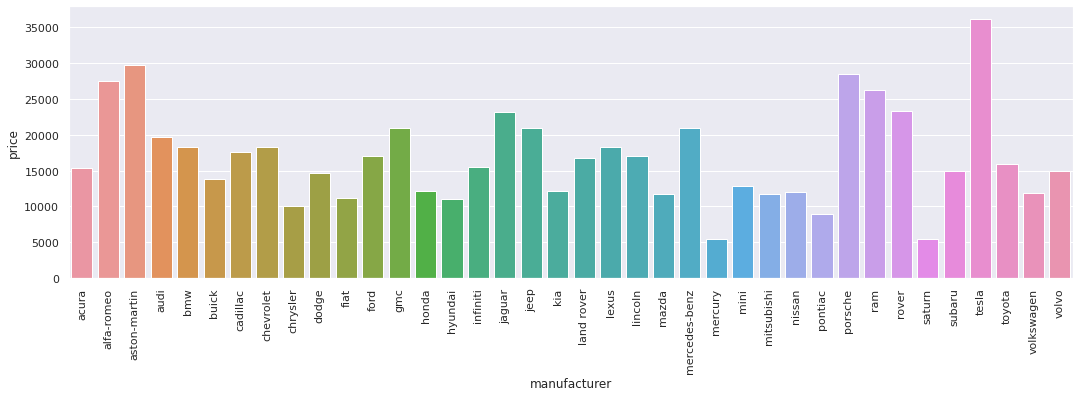

In [181]:
# Mean price per manufacturer

price_ave = cars[['price','manufacturer']].groupby('manufacturer').mean()

plt.figure(figsize=(18,5))
pr = sns.barplot(x=price_ave.index, y="price", data=price_ave)
var = pr.set_xticklabels(pr.get_xticklabels(), rotation=90)

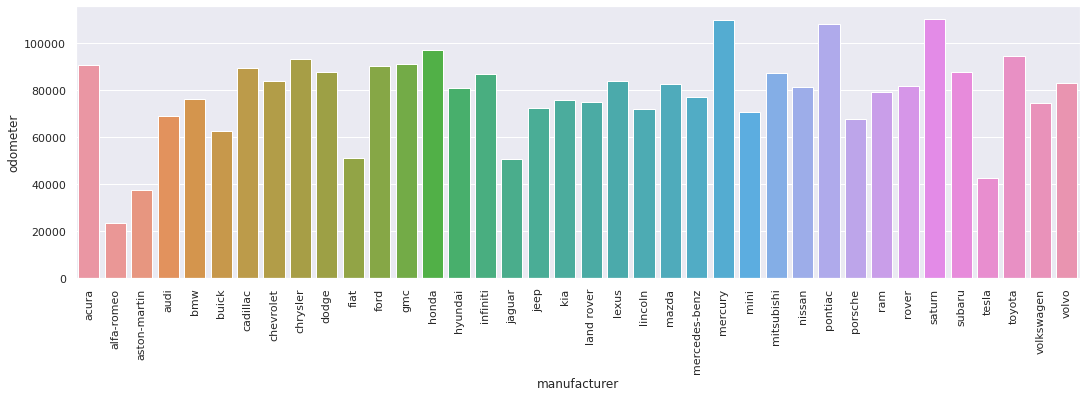

In [182]:
# Odometer mean per manufacturer

odometer_mean = cars[['odometer','manufacturer']].groupby('manufacturer').mean()

plt.figure(figsize=(18,5))
pr = sns.barplot(x=odometer_mean.index, y="odometer", data=odometer_mean)
var = pr.set_xticklabels(pr.get_xticklabels(), rotation=90)

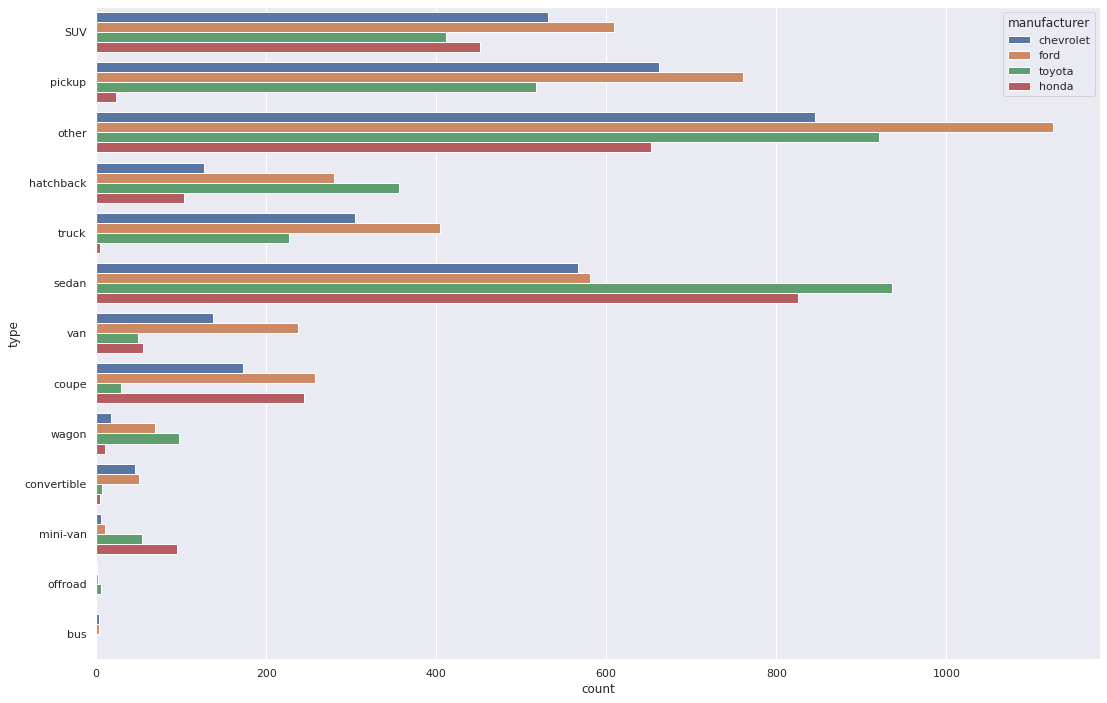

In [183]:
# Breakdown of the top4 manufacturers:
top4 = ['ford', 'chevrolet', 'toyota', 'honda']

v = cars.loc[(cars['manufacturer'].isin(top4)), :].copy()

plt.subplots(figsize=(18, 12)) 
sns.countplot(y="type", hue="manufacturer", data=v)

###Hope you enjoyed the project.